In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D, Reshape
from warnings import simplefilter,filterwarnings
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Sequential
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from experta import *
import pandas as pd
import numpy as np
import scipy.io
import pickle
import glob
import sys
import gc
import os
import re
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [3]:
data_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\DataSet"
results_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\Results"
code_path = "C:\\Users\\user\\Python_Anaconda\\task\\06\\Code"
model_info_path = os.path.join(results_path,'model info')

In [4]:
dataset = pd.read_csv(os.path.join(data_path,"new_test_dayaset.csv"),)
print(dataset.shape)
dataset.head()

(1508, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


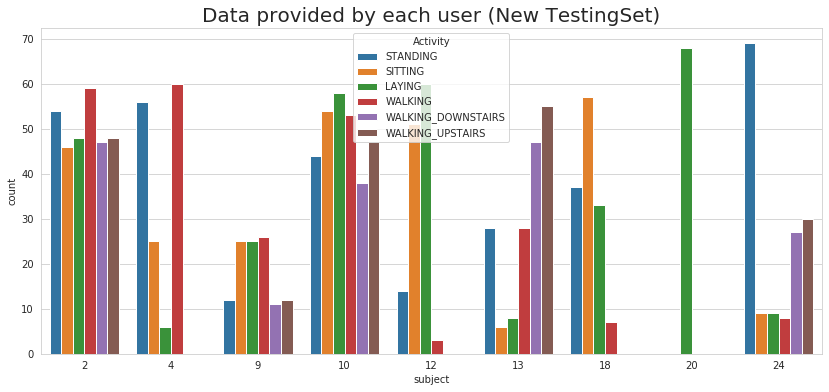

In [5]:
plt.figure(figsize=(14,6))
plt.title('Data provided by each user (New TestingSet)', fontsize=20)
sns.countplot(x='subject',hue='Activity', data = dataset)
plt.show()

In [6]:
def save_object(obj, filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()
    
def load_object(filename,path):
    filename = os.path.join(path,filename)
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [7]:
class Healthy(Fact):
    pass
class FootPain(Fact):
    pass
class Insomnia(Fact):
    pass
class Obesity(Fact):
    pass
class Arthritis(Fact):
    pass
class HeartAndBloodVesselProblems(Fact):
    pass
class Bedsores(Fact):
    pass
class BackPains(Fact):
    pass

In [8]:
class DiseasesDetectionBasedActivities(KnowledgeEngine):
    
    def __init__(self, activites):
        super().__init__()
        self.activites = activites
        self.important_activites = []
        self.important_number_activites = []
        self.other_activites = []
        self.other_number_activites = []        
        self.Disease = 'Healthy'

    @Rule(NOT(Fact(ID = W())))
    def FillFacts(self):
        activites_count, base_number = self.calculate_counter()
        for key in activites_count:
            if key[1]>=base_number:
                self.important_activites.append(key[0])
                self.important_number_activites.append(key[1])
            else:
                self.other_activites.append(key[0])
                self.other_number_activites.append(key[1])
    def calculate_counter(self):
        uniqe_activites = set(self.activites)
        activity_dic = {key:0 for key in uniqe_activites}
        for i, x in enumerate(self.activites):
            activity_dic[x]+=1
        return sorted(activity_dic.items(), key=lambda x: x[1]), np.ceil(len(self.activites)/len(uniqe_activites))
    
    @Rule(NOT(FootPain(foot_pain = W())))
    def FootPain_(self):
        foot_pain = False
        if np.array_equal(np.sort(self.important_activites), np.sort(['WALKING', 'STANDING'])) and self.other_activites[self.other_number_activites.index(max(self.other_number_activites))]=='SITTING':
            foot_pain = True
        self.declare(FootPain(foot_pain = foot_pain))

    @Rule(NOT(Insomnia(insomnia = W())))
    def Insomnia_(self):
        insomnia = False
        if np.array_equal(np.sort(self.important_activites), np.sort(['LAYING', 'SITTING', 'WALKING'])) and np.array_equal(np.sort(self.other_activites), np.sort(['WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'STANDING'])):
            insomnia  = True
        self.declare(Insomnia(insomnia = insomnia))
    
    @Rule(NOT(Obesity(obesity = W())))
    def Obesity_(self):
        obesity = False
        if np.array_equal(np.sort(self.important_activites), np.sort(['SITTING', 'LAYING'])) and self.other_activites[self.other_number_activites.index(max(self.other_number_activites))]=='STANDING':
            obesity = True
        self.declare(Obesity(obesity = obesity))
    
    @Rule(NOT(Bedsores(bedsores = W())))
    def Bedsores_(self):
        bedsores = False
        if np.array_equal(self.important_activites, ['LAYING']):
            bedsores = True
        self.declare(Bedsores(bedsores = bedsores))
    
    @Rule(NOT(Arthritis(arthritis = W())))
    def Arthritis_(self):
        arthritis = False
        if np.array_equal(np.sort(self.important_activites), np.sort(['WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])):
            arthritis = True
        self.declare(Arthritis(arthritis = arthritis))
        
    @Rule(NOT(HeartAndBloodVesselProblems(heart_and_blood_vessel_problems = W())))
    def Heart_and_blood_vessel_problems_(self):
        heart_and_blood_vessel_problems = False
        if self.important_activites[self.important_number_activites.index(max(self.important_number_activites))]=='SITTING' and self.other_activites[self.other_number_activites.index(max(self.other_number_activites))]=='LAYING':
            heart_and_blood_vessel_problems=True
        self.declare(HeartAndBloodVesselProblems(heart_and_blood_vessel_problems = heart_and_blood_vessel_problems))
    
    @Rule(NOT(BackPains(back_pains = W())))
    def BackPains_(self):
        back_pains = False
        if self.important_activites[self.important_number_activites.index(max(self.important_number_activites))]=='STANDING' and np.array_equal(np.sort(self.important_activites), np.sort(['STANDING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])): 
            back_pains = True
        self.declare(BackPains(back_pains = back_pains))

    @Rule(FootPain(foot_pain = L(True)))
    def Foot_Pain_test(self):
        self.Disease = 'Foot Pain'
        
    @Rule(Insomnia(insomnia = L(True)))
    def Insomnia_test(self):
        self.Disease = 'Healthy But sometimes Have Insomnia'
        
    @Rule(Obesity(obesity = L(True)))
    def Obesity_test(self):
        self.Disease = 'Obesity'
        
    @Rule(Bedsores(bedsores = L(True)))
    def Bedsores_test(self):
        self.Disease = 'Bedsores'
        
    @Rule(Arthritis(arthritis = L(True)))
    def Arthritis_test(self):
        self.Disease = 'Arthritis'
 
    @Rule(HeartAndBloodVesselProblems(heart_and_blood_vessel_problems = L(True)))
    def HeartAndBloodVesselProblems_test(self):
        self.Disease = 'Heart And Blood Vessel Problems'
   
    @Rule(BackPains(back_pains = L(True)))
    def BackPains_test(self):
        self.Disease = 'Back Pains'

In [9]:
def ExpertSystem(activites):
    engine = DiseasesDetectionBasedActivities(activites)
    engine.reset()
    engine.run()
    return engine.Disease

In [11]:
def HumanActivityPredection(X, y, label_encoder):
    model_name = "CNN_Network_"
    model = load_model(filepath=os.path.join(model_info_path ,model_name+".h5"))
    y_pred = model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    activites = label_encoder.inverse_transform(y_pred)
    return activites

In [12]:
def Pipeline(subject_id, CSV_file=None):
    CSV_file = pd.read_csv(os.path.join(data_path,"new_test_dayaset.csv"),) if CSV_file is None else CSV_file
    subject_recordes = CSV_file[CSV_file['subject']==int(subject_id)]
    label_encoder = load_object("label_encoder", results_path)
    X = subject_recordes.drop('Activity', axis=1)
    y = np.array(subject_recordes['Activity'].tolist())
    y = label_encoder.transform(y)
    y = to_categorical(y, 6)
    X = X.values.reshape(-1, 1, X.shape[1])
    activites = HumanActivityPredection(X, y, label_encoder)
    Disease = ExpertSystem(activites)
    DiseaseFromReallActivites = ExpertSystem(subject_recordes['Activity'].tolist())
    return Disease, DiseaseFromReallActivites

In [13]:
for Subject_id in set(dataset['subject']):
    print(25*"*", "Subject Number : ", Subject_id, 25*"*","\n")
    Disease, DiseaseFromReallActivites = Pipeline(Subject_id, dataset)
    print("The Disease From predicted Activity  is : ", Disease,"\n")
    print("The Disease From Reall Activity  is : ", DiseaseFromReallActivites,"\n")   

************************* Subject Number :  2 ************************* 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


The Disease From predicted Activity  is :  Healthy 

The Disease From Reall Activity  is :  Healthy 

************************* Subject Number :  4 ************************* 

The Disease From predicted Activity  is :  Foot Pain 

The Disease From Reall Activity  is :  Foot Pain 

************************* Subject Number :  9 ************************* 

The Disease From predicted Activity  is :  Healthy But sometimes Have Insomnia 

The Disease From Reall Activity  is :  Healthy But sometimes Have Insomnia 

************************* Subject Number :  10 ************************* 

The Disease From predicted Activity  is :  Healthy 

The Disease From Reall Activity  is :  Healthy But sometimes Have Insomnia 

************************* Subject Number :  12 ************************* 

The Disease From predicted Activity  is :  Obesity 

The Disease From Reall Activity  is :  Obesity 

************************* Subject Number :  13 ************************* 

The Disease From predicted Ac